## Emotional classification with 13 classes using SMOTE and Grid Search

In [8]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [9]:
##train_data = pd.read_csv("../input/emotions-dataset-for-nlp/train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")

df = pd.read_csv("C:/Users/ranja/Desktop/Emotion_final/tweet_13_emotions.csv")

In [10]:
EMBEDDING_FILE= f'C:/Users/ranja/Desktop/Emotion_final/glove.6B.100d.txt'  #GloVe file path
EMBEDDING_FILE

'C:/Users/ranja/Desktop/Emotion_final/glove.6B.100d.txt'

In [11]:
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


C:\Users\ranja\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

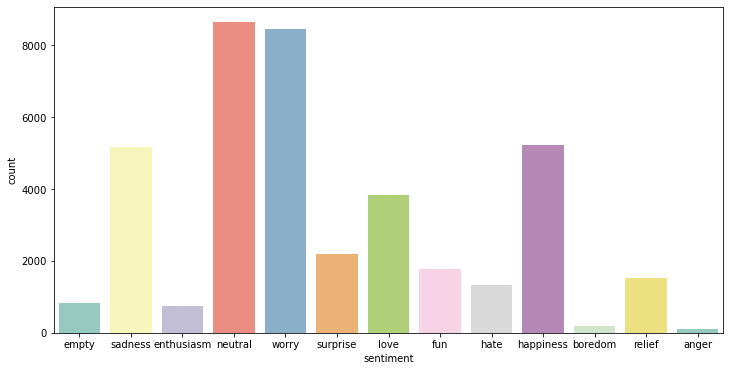

In [12]:
# sns.countplot(df.sentiment)
# plt.figure(figsize = (12,6))
# plt.show()
plt.figure(figsize = (12,6))
sns.countplot(df["sentiment"], palette='Set3')

In [13]:
df['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [14]:
df=df.dropna() #Drop columns with NA values
X=df.drop('sentiment',axis=1) #Input
y=df['sentiment'] #Output

In [15]:
messages=X.copy()
messages.reset_index(inplace=True) #Drop NA may cause inconsistency in index

In [16]:
nltk.download('stopwords')
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['content'][i]) #Remove Special Characters
    review = review.lower() #Lower case 
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')] #Remove stopwords
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ranja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
corpus[:10]

['tiffanylu know listenin bad habit earlier start freakin part',
 'layin n bed headach ughhhh waitin call',
 'funer ceremoni gloomi friday',
 'want hang friend soon',
 'dannycastillo want trade someon houston ticket one',
 'ping ghostridah go prom bc bf like friend',
 'sleep im think old friend want marri damn amp want scandal',
 'hmmm http www djhero com',
 'charviray charlen love miss',
 'kelcouch sorri least friday']

In [18]:
#Creating the dictionary with word as key and pretrained-value array as value
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding='utf-8'))

#Calculate mean and std for the pretrained weights
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
print(emb_mean,emb_std)

C:\Users\ranja\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


0.004451992 0.4081574


In [19]:
voc_size=10000 # Vocabulary size
embed_size=100 #word vector size

tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(list(corpus))
word_index = tokenizer.word_index #Total words in the corpus
nb_words = min(voc_size, len(word_index))

#Initialize weight matrix for embedding layer
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size)) 

for word, i in word_index.items():
    if i >= voc_size: continue #Skip the words if vocab size is reached
    embedding_vector = embeddings_index.get(word) #Extract the pretrained values from GloVe
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [20]:
#Contains the pretrained GloVe weights for the words
len(embedding_matrix)

10000

In [21]:
#One hot representation for input
onehot_repr=[one_hot(words,voc_size)for words in corpus]

#Finding max words
l = 0
for x in corpus:
    l = max(l,len(x.split(' ')))

#Padding the sequences for input
sent_length= l
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)

In [22]:
print(embedded_docs)

[[   0    0    0 ... 3291 6368 5800]
 [   0    0    0 ... 8454 9712 3234]
 [   0    0    0 ... 7820  959 9059]
 ...
 [   0    0    0 ... 5784 8250 5472]
 [   0    0    0 ... 4502 4507 1952]
 [   0    0    0 ... 6987 8576 4949]]


In [23]:
#Encoding the target outputs to integers
label_encoder = preprocessing.LabelEncoder()

X_final=np.array(embedded_docs) #input to array
y = label_encoder.fit_transform(y)
y_final=np.array(y)
print(y_final)

[ 2 10 10 ...  7  5  7]


In [24]:
X_final.shape,y_final.shape

((40000, 32), (40000,))

In [25]:
#Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, 
                                                    test_size=0.2, random_state=42) 
#Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.1, random_state=21) 

In [26]:
y_test.shape, y_val.shape

((8000,), (3200,))

In [27]:
X_train.shape, y_train.shape

((28800, 32), (28800,))

In [28]:
from imblearn.over_sampling import SMOTE

In [29]:
#pip install imblearn

In [30]:
y

array([ 2, 10, 10, ...,  7,  5,  7])

In [31]:
y_final

array([ 2, 10, 10, ...,  7,  5,  7])

In [32]:
X_final

array([[   0,    0,    0, ..., 3291, 6368, 5800],
       [   0,    0,    0, ..., 8454, 9712, 3234],
       [   0,    0,    0, ..., 7820,  959, 9059],
       ...,
       [   0,    0,    0, ..., 5784, 8250, 5472],
       [   0,    0,    0, ..., 4502, 4507, 1952],
       [   0,    0,    0, ..., 6987, 8576, 4949]])

#### SMOTE

In [33]:
sm = SMOTE(random_state = 42)

x_new, y_new = sm.fit_resample(X_final, y_final)


In [34]:
x_new.shape, X_final.shape, y_new.shape, y_final.shape

((112294, 32), (40000, 32), (112294,), (40000,))

In [35]:
x_new = pd.DataFrame(x_new)
X_final = pd.DataFrame(X_final)
y_new = pd.DataFrame(y_new)
y_final = pd.DataFrame(y_final)

In [36]:
y_new.value_counts()

0     8638
1     8638
2     8638
3     8638
4     8638
5     8638
6     8638
7     8638
8     8638
9     8638
10    8638
11    8638
12    8638
dtype: int64

In [37]:
y_final.value_counts()

8     8638
12    8459
5     5209
10    5165
7     3842
11    2187
4     1776
9     1526
6     1323
2      827
3      759
1      179
0      110
dtype: int64

In [38]:
y_new = y_new.to_numpy()

In [39]:
y_new

array([[ 2],
       [10],
       [10],
       ...,
       [12],
       [12],
       [12]])

In [40]:
x_new

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0,0,0,0,0,0,0,0,0,0,...,0,1937,9032,2871,7413,5675,2946,3291,6368,5800
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,8295,3872,1399,5319,8454,9712,3234
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8460,7820,959,9059
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9401,106,7350,1363
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2635,9401,2336,8250,5168,2159,6785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112289,0,0,0,0,0,0,0,0,0,0,...,6574,5751,9648,3989,6486,1475,3957,1338,8179,1612
112290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4594,1614,1738,2456,9079,9222
112291,0,0,0,0,0,0,0,0,0,0,...,711,6595,1678,4370,8733,835,1575,847,3808,1157
112292,0,0,0,0,0,0,0,0,0,0,...,1092,2760,7940,4536,4571,5090,8641,1423,5769,6358


In [41]:
x_new = x_new.to_numpy()

### Hyperparameter tuning

In [45]:
#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

learning_rate = [0.001, 0.002, 0.005, 0.01] # 0.001, 0.005, 0.01
batch_size = [32, 64, 128] # 16, 24, 32, 64, 128
#epocs = [50,70,100]
dropout = [0.2, 0.3] # usually <= 0.3, [0, 0.1, 0.2, 0.3]
neuron = [32, 64, 128]
param_grid = dict(learning_rate=learning_rate, batch_size=batch_size,  dropout=dropout, neuron=neuron)

In [42]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from keras.metrics import Precision, Recall
import tensorflow as tf

In [47]:
def create_model(learning_rate=learning_rate, dropout=dropout, neuron=neuron):
    # next we can build the model exactly like we would normally do it
    model=Sequential()
    #model.add(Embedding(voc_size, embed_size, weights=[embedding_matrix]))
    
    model.add(Embedding(input_dim=voc_size, output_dim =100 ,input_length=32))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout))

# model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
# model.add(MaxPooling1D(pool_size=5))
# #model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(13, activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])
    # model.summary()
    return model

In [48]:
my_model_history = KerasClassifier(build_fn=create_model, epochs=100, batch_size=batch_size, verbose=3)

<ipython-input-48-2484f0e62136>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  my_model_history = KerasClassifier(build_fn=create_model, epochs=100, batch_size=batch_size, verbose=3)


In [65]:
#Grid Search fitting in dataset
# grid = GridSearchCV(estimator=my_model_history, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(x_new, y_new)

In [64]:
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

### Model Building

In [43]:
# Creating model 1: CNN - LeNet-5
model=Sequential()
#model.add(Embedding(voc_size, embed_size, weights=[embedding_matrix]))

model.add(Embedding(input_dim=voc_size, output_dim =100 ,input_length=32))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
# model.add(MaxPooling1D(pool_size=5))
# #model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(13, activation='softmax'))

#model.add(Dense(6,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           1000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 64)            19264     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 64)            0         
 1D)                                                  

##### Training CNN model

In [ ]:
# Training CNN model
model_save = ModelCheckpoint('weights_CNN.h5', save_best_only = True, save_weights_only = True, 
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
history = model.fit(x_new, y_new,validation_data=(X_val,y_val),epochs=50,batch_size=64,callbacks = [model_save])

Epoch 1/50
1754/1755 [============================>.] - ETA: 0s - loss: 2.4034 - accuracy: 0.1447
Epoch 00001: val_loss improved from inf to 2.14759, saving model to weights_CNN.h5
1755/1755 [==============================] - 38s 21ms/step - loss: 2.4033 - accuracy: 0.1448 - val_loss: 2.1476 - val_accuracy: 0.2403
Epoch 2/50
1753/1755 [============================>.] - ETA: 0s - loss: 2.2982 - accuracy: 0.1800
Epoch 00002: val_loss improved from 2.14759 to 2.01426, saving model to weights_CNN.h5
1755/1755 [==============================] - 37s 21ms/step - loss: 2.2982 - accuracy: 0.1800 - val_loss: 2.0143 - val_accuracy: 0.2872
Epoch 3/50
1755/1755 [==============================] - ETA: 0s - loss: 2.2276 - accuracy: 0.2042
Epoch 00003: val_loss improved from 2.01426 to 1.88445, saving model to weights_CNN.h5
1755/1755 [==============================] - 35s 20ms/step - loss: 2.2276 - accuracy: 0.2042 - val_loss: 1.8845 - val_accuracy: 0.3481
Epoch 4/50
1755/1755 [======================

Epoch 27/50
1755/1755 [==============================] - ETA: 0s - loss: 1.0443 - accuracy: 0.6345
Epoch 00027: val_loss improved from 0.95902 to 0.94382, saving model to weights_CNN.h5
1755/1755 [==============================] - 33s 19ms/step - loss: 1.0443 - accuracy: 0.6345 - val_loss: 0.9438 - val_accuracy: 0.6728
Epoch 28/50
1754/1755 [============================>.] - ETA: 0s - loss: 1.0273 - accuracy: 0.6411
Epoch 00028: val_loss improved from 0.94382 to 0.92872, saving model to weights_CNN.h5
1755/1755 [==============================] - 52s 30ms/step - loss: 1.0273 - accuracy: 0.6411 - val_loss: 0.9287 - val_accuracy: 0.6816
Epoch 29/50
1752/1755 [============================>.] - ETA: 0s - loss: 1.0160 - accuracy: 0.6450
Epoch 00029: val_loss improved from 0.92872 to 0.91927, saving model to weights_CNN.h5
1755/1755 [==============================] - 33s 19ms/step - loss: 1.0158 - accuracy: 0.6451 - val_loss: 0.9193 - val_accuracy: 0.7234
Epoch 30/50
1754/1755 [==============

##### Plotting Model Accuracy and Loss

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


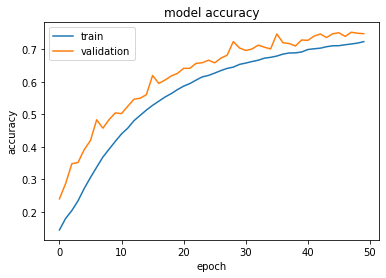

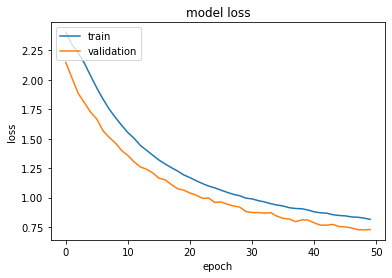

In [45]:
#Plotting Model Accuracy and Loss
print(history.history.keys())
#  "Accuracy"
#plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
#plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [46]:
#Load the best weights
model.load_weights('weights_CNN.h5')

##### printing y_pred for x_test 

In [47]:
#y_pred=model.predict_classes(X_test)
#print(y_pred)

predict_x=model.predict(X_test) 
y_pred=np.argmax(predict_x,axis=1)
print(y_pred)

[ 2  2  7 ...  1 11  7]


#### Accuracy of test prediction

In [48]:
#Accuracy score
print(accuracy_score(y_test,y_pred))

0.756625


#### Classification report

In [49]:
#Classification report
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.55000   0.57895   0.56410        19
           1    0.76190   0.51613   0.61538        31
           2    0.14868   0.76543   0.24900       162
           3    0.72441   0.56442   0.63448       163
           4    0.83688   0.69822   0.76129       338
           5    0.78858   0.85992   0.82271      1028
           6    0.91176   0.80970   0.85771       268
           7    0.88146   0.76115   0.81690       762
           8    0.80935   0.76609   0.78713      1740
           9    0.65734   0.53409   0.58934       352
          10    0.91337   0.70554   0.79612      1046
          11    0.73265   0.67059   0.70025       425
          12    0.85978   0.80972   0.83400      1666

    accuracy                        0.75663      8000
   macro avg    0.73663   0.69538   0.69449      8000
weighted avg    0.81557   0.75662   0.77822      8000



##### Confusion Matrix

Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)


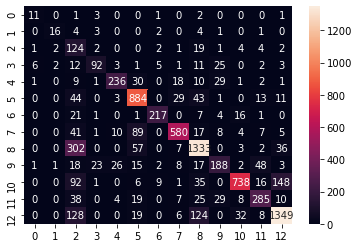

In [50]:
#Confusion Matrix
print('Confusion Matrix')
print(sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt="d"))

#### Confusion matrix diagonal entries after normalization

In [60]:
from sklearn.metrics import confusion_matrix
import numpy as np
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#Now the normalize the diagonal entries
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#The diagonal entries are the accuracies of each class
cm.diagonal()

array([0.57894737, 0.51612903, 0.7654321 , 0.56441718, 0.69822485,
       0.85992218, 0.80970149, 0.76115486, 0.76609195, 0.53409091,
       0.70554493, 0.67058824, 0.80972389])

In [61]:
cm_diag = cm.diagonal()
type(cm_diag)

numpy.ndarray

##### Mapping of target classes using label-encoder

In [62]:
#Mapping of target classes using label-encoder
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'anger': 0, 'boredom': 1, 'empty': 2, 'enthusiasm': 3, 'fun': 4, 'happiness': 5, 'hate': 6, 'love': 7, 'neutral': 8, 'relief': 9, 'sadness': 10, 'surprise': 11, 'worry': 12}


##### Accuracy Class-wise

In [63]:
label = dict(zip(label_encoder.classes_,cm_diag ))
label # printing class-wise accuracy

{'anger': 0.5789473684210527,
 'boredom': 0.5161290322580645,
 'empty': 0.7654320987654321,
 'enthusiasm': 0.5644171779141104,
 'fun': 0.6982248520710059,
 'happiness': 0.8599221789883269,
 'hate': 0.8097014925373134,
 'love': 0.7611548556430446,
 'neutral': 0.7660919540229885,
 'relief': 0.5340909090909091,
 'sadness': 0.7055449330783938,
 'surprise': 0.6705882352941176,
 'worry': 0.8097238895558223}

In [59]:
#Mapping of target classes using label-encoder
# le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print(le_name_mapping)

#### Making prediction with examples

In [52]:
#Example
def predict_emotion(stri):
    review = re.sub('[^a-zA-Z]', ' ', stri)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    onehot_repr = [one_hot(review,voc_size)] 
    embed = pad_sequences(onehot_repr, padding='pre', maxlen=sent_length)
    predicti = model.predict(embed)
    return label_encoder.classes_[np.argmax(predicti)]

###### predict_emotion('I am feeling so joyful today')

In [53]:
predict_emotion('I am feeling so joyful today')

'worry'

###### predict_emotion('He is an arrogant and rude person')

In [54]:
predict_emotion('He is an arrogant and rude person')

'empty'

###### predict_emotion('The teacher is intimidating and scary')

In [55]:
predict_emotion('The teacher is intimidating and scary')

'surprise'

###### predict_emotion('I just lost my purse.')

In [56]:
predict_emotion('I just lost my purse.')

'empty'

###### predict_emotion('I just lost my purse.')

In [57]:
predict_emotion('I am very happy that tomorrow will be a holiday')

'love'